# **Importing the libraries**

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

# **Loading the Images**

In [2]:
X = []
Y = []

for i in tqdm(glob('/kaggle/input/mrl-dataset/train/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('/kaggle/input/mrl-dataset/train/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(0)    

100%|██████████| 2000/2000 [00:14<00:00, 135.23it/s]


# **Normalizing the images (with any algorithm)**

In [3]:
# X = np.array(X)
# X = X/255.0
# Y = np.array(Y)

# **Normalizing the images using Min-Max Scaling algorithm**

In [4]:
X = (np.array(X) - np.min(X)) / (np.max(X) - np.min(X))
X = X/255.0
Y = (np.array(Y) - np.min(Y)) / (np.max(Y) - np.min(Y))

# **Normalizing the images using Z-Score algorithm**

In [5]:
# 'X = (np.array(X) - np.mean(X)) / np.std(X)
# X = X/255.0
# Y = (np.array(Y) - np.mean(Y)) / np.std(Y)'

# Expanding the dimensions of array (numpy)

In [6]:
X = np.expand_dims(X,-1)

# Spliting the dataset into training and testing data

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# CNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten

model = tf.keras.models.Sequential([
      Input(shape=(64, 64, 1)),

      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu'),
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Flatten(),
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),

      Dense(units = 1, activation = 'sigmoid')
  ])

# Compiling the Model

In [9]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

# Training of the Model

In [10]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestModel.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)
model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9277
Epoch 1: val_loss improved from inf to 0.72456, saving model to bestModel.h5
67/67 [==============================] - 38s 536ms/step - loss: 0.1819 - accuracy: 0.9277 - val_loss: 0.7246 - val_accuracy: 0.5187
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9813
Epoch 2: val_loss did not improve from 0.72456
67/67 [==============================] - 35s 530ms/step - loss: 0.0674 - accuracy: 0.9813 - val_loss: 0.7938 - val_accuracy: 0.5187
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9874
Epoch 3: val_loss did not improve from 0.72456
67/67 [==============================] - 35s 529ms/step - loss: 0.0422 - accuracy: 0.9874 - val_loss: 1.2750 - val_accuracy: 0.5187
Epoch 4/30
67/67 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9832
Epoch 4: val_loss did not improve from 0.72456
67/67 [===

# Model Evaluation

In [11]:
model.evaluate(x_test, y_test)

42/42 [==============================] - 4s 94ms/step - loss: 10.8007 - accuracy: 0.5212


[10.800714492797852, 0.521212100982666]

# Loading the Model Performance

In [12]:
from keras.models import load_model
best_model = load_model('/kaggle/working/bestModel.h5')
best_model.evaluate(x_test, y_test)

42/42 [==============================] - 4s 96ms/step - loss: 0.0014 - accuracy: 0.9992


[0.0014001838862895966, 0.9992424249649048]

# Changing the dimensions and Plotting the trained images

1/1 [==============================] - 0s 192ms/step


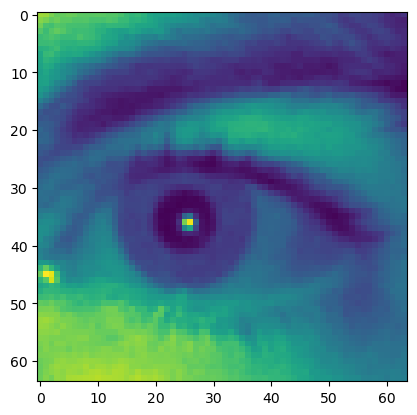

Open
1/1 [==============================] - 0s 28ms/step


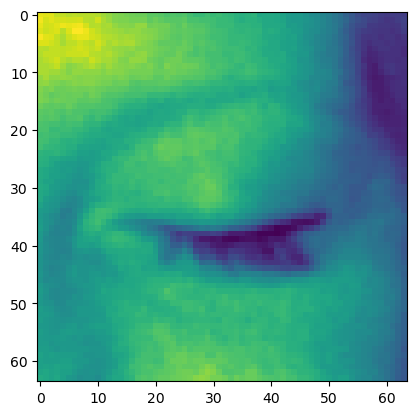

Closed
1/1 [==============================] - 0s 27ms/step


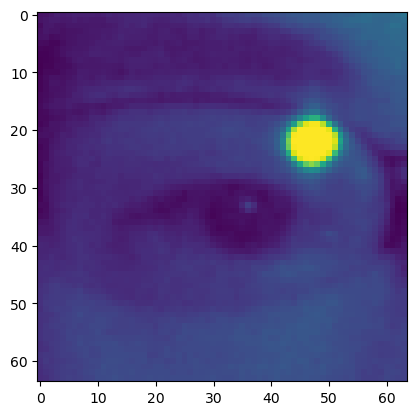

Open
1/1 [==============================] - 0s 27ms/step


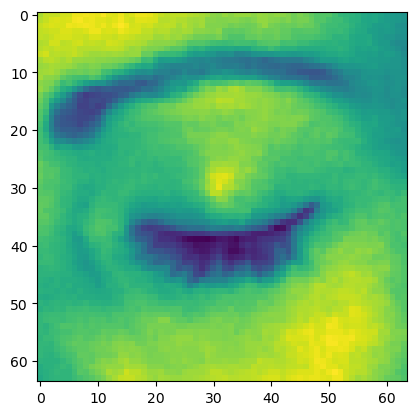

Closed
1/1 [==============================] - 0s 32ms/step


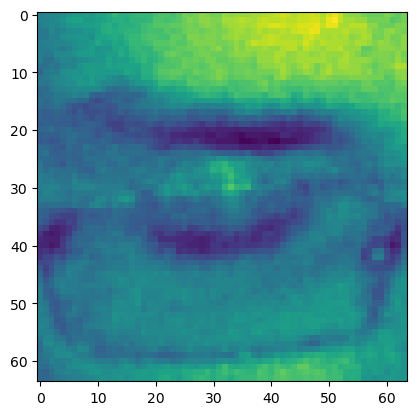

Closed


In [13]:
for i in x_test[0:5]:
    result = best_model.predict(np.expand_dims(i,0))
    plt.imshow(i)
    plt.show()
    
    if result > 0.5:
        print('Open')
    else:
        print("Closed")
    

# Prediction and Confusion Matrix

42/42 [==============================] - 4s 104ms/step


Text(0.5, 25.722222222222214, 'Actual')

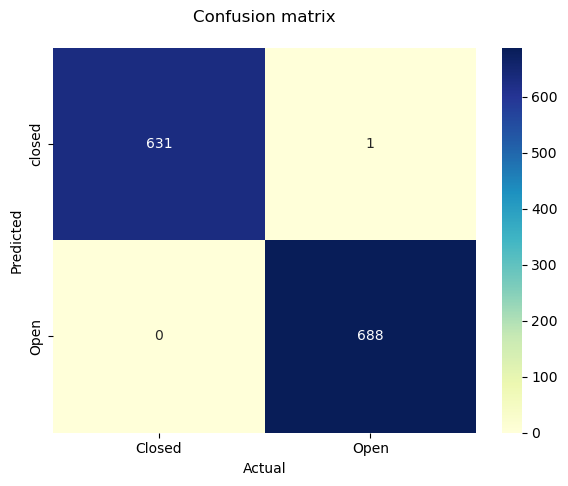

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

# Accuracy

Evaluating the Accuracy

In [15]:
accuracy = best_model.evaluate(x_test, y_test)[1]
print("Accuracy:", accuracy)

42/42 [==============================] - 4s 96ms/step - loss: 0.0014 - accuracy: 0.9992
Accuracy: 0.9992424249649048
